<a href="https://colab.research.google.com/github/jonesLevin/TensorFlow-Deep-Learning/blob/main/Transfer_Learning_Scaling_Up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning on Whole Food101 Dataset

In [1]:
!nvidia-smi

Thu Apr 27 06:48:36 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## creating helper functions



In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-04-27 06:48:38--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-04-27 06:48:39 (99.1 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import series of helper functions
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

## 101 Food Classes: Working With Less Data

In [4]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

--2023-04-27 06:48:43--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.10.128, 142.251.12.128, 172.217.194.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.10.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  24.0MB/s    in 68s     

2023-04-27 06:49:51 (22.9 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [5]:
unzip_data('101_food_classes_10_percent.zip')

In [6]:
train_dir = '101_food_classes_10_percent/train'
test_dir = '101_food_classes_10_percent/test'

In [7]:
# How many image classes are there
walk_through_dir('101_food_classes_10_percent')

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/foie_gras'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/lobster_bisque'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/club_sandwich'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/chicken_quesadilla'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/huevos_rancheros'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/grilled_cheese_sandwich'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/beef_carpaccio'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/nachos'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/breakfast_burrito'.
There are

In [8]:
# Setup data inputs
import tensorflow as tf
from tensorflow import keras

IMG_SIZE = (224, 224)
train_data_all_10_percent = keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                             label_mode='categorical',
                                                                             image_size=IMG_SIZE)
test_data = keras.preprocessing.image_dataset_from_directory(test_dir,
                                                             label_mode='categorical',
                                                             image_size=IMG_SIZE,
                                                             shuffle=False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a Big Model With Transfer Learning 

Here are the steps we are going to take:
* Create a model checkpoint callback
* Create a data augmentation layer
* Build a headless function efficient net base model
* Compile the model
* Feature extract for 5 epochs on the train data
* Validate on 15% of the test data

In [9]:
# Create checkpoint callback
checkpoint_path = '101_food_classes_10_percent_data_model_checkpoint'
checkpoint_callback = keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_weights_only=True,
                                                      monitor='val_accuracy',
                                                      save_best_only=True)

In [10]:
# Create the data augmentation layer
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip('horizontal'),
    keras.layers.RandomRotation(.2),
    keras.layers.RandomHeight(.2),
    keras.layers.RandomWidth(.2),
    keras.layers.RandomZoom(.2)
], name='data_augmentation_layer')

In [12]:
# Building a feature extractor base model
base_model = keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture
inputs = keras.layers.Input(shape=(224, 224, 3), name='input_layer')
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)
outputs = keras.layers.Dense(len(train_data_all_10_percent.class_names), activation='softmax', name='output_layer')(x)
model = keras.Model(inputs, outputs)

16705208/16705208 [==============================] - 2s 0us/step


In [13]:
# Get the model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation_layer (Se  (None, None, None, 3)    0         
 quential)                                                       
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [14]:
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

In [15]:
# Fit the model on the training data
history = model.fit(train_data_all_10_percent,
                    epochs=5,
                    validation_data=test_data,
                    validation_steps=int(.15 * len(test_data)),
                    callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 111s 404ms/step - loss: 3.3684 - accuracy: 0.2767 - val_loss: 2.6092 - val_accuracy: 0.4102
Epoch 2/5
237/237 [==============================] - 73s 307ms/step - loss: 2.2057 - accuracy: 0.4970 - val_loss: 2.1024 - val_accuracy: 0.4913
Epoch 3/5
237/237 [==============================] - 60s 252ms/step - loss: 1.8263 - accuracy: 0.5715 - val_loss: 1.9373 - val_accuracy: 0.5124
Epoch 4/5
237/237 [==============================] - 60s 253ms/step - loss: 1.6057 - accuracy: 0.6108 - val_loss: 1.8767 - val_accuracy: 0.5188
Epoch 5/5
237/237 [==============================] - 57s 236ms/step - loss: 1.4474 - accuracy: 0.6481 - val_loss: 1.8123 - val_accuracy: 0.5215


In [16]:
# Evaluate on the whole test data
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

790/790 [==============================] - 57s 71ms/step - loss: 1.5831 - accuracy: 0.5824


[1.5830795764923096, 0.5824158191680908]

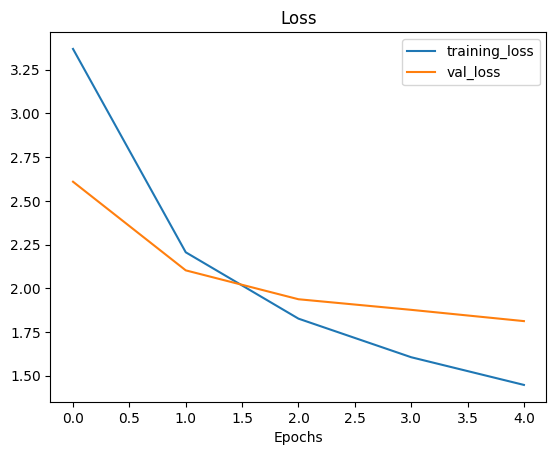

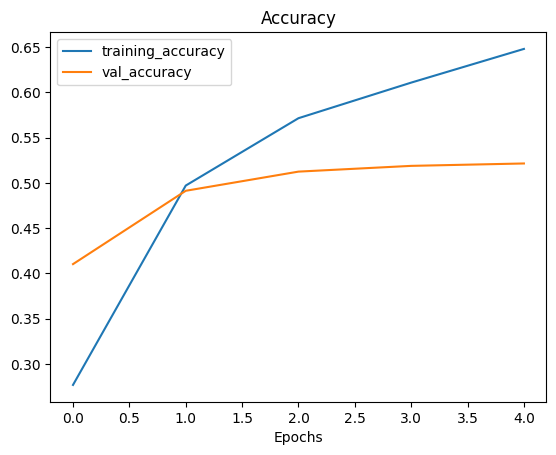

In [17]:
plot_loss_curves(history)

## Fine-Tuning

In [18]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [19]:
# Recompile model with lower learning rate
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

In [20]:
# What layers in the model are trainable
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation_layer True
efficientnetb0 True
global_average_pooling_layer True
output_layer True


In [21]:
# What layers are trainable in the base model
for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False
39

In [22]:
# Fine tunining the model
fine_tune_epochs = 10

history_fine_tune = model.fit(train_data_all_10_percent,
                              epochs=fine_tune_epochs,
                              validation_data=test_data,
                              validation_steps=int(0.15 * len(test_data)),
                              initial_epoch=history.epoch[-1])

Epoch 5/10
237/237 [==============================] - 65s 235ms/step - loss: 1.2134 - accuracy: 0.6821 - val_loss: 1.7748 - val_accuracy: 0.5334
Epoch 6/10
237/237 [==============================] - 49s 204ms/step - loss: 1.1046 - accuracy: 0.7038 - val_loss: 1.7409 - val_accuracy: 0.5418
Epoch 7/10
237/237 [==============================] - 46s 192ms/step - loss: 1.0148 - accuracy: 0.7282 - val_loss: 1.7911 - val_accuracy: 0.5297
Epoch 8/10
237/237 [==============================] - 42s 176ms/step - loss: 0.9452 - accuracy: 0.7485 - val_loss: 1.7695 - val_accuracy: 0.5387
Epoch 9/10
237/237 [==============================] - 45s 186ms/step - loss: 0.8825 - accuracy: 0.7616 - val_loss: 1.7516 - val_accuracy: 0.5434
Epoch 10/10
237/237 [==============================] - 44s 184ms/step - loss: 0.8328 - accuracy: 0.7757 - val_loss: 1.7633 - val_accuracy: 0.5403


In [24]:
# Evaluate on the whole test data
fine_tune_results = model.evaluate(test_data)
fine_tune_results

790/790 [==============================] - 55s 69ms/step - loss: 1.5141 - accuracy: 0.5995


[1.5141353607177734, 0.5994851589202881]

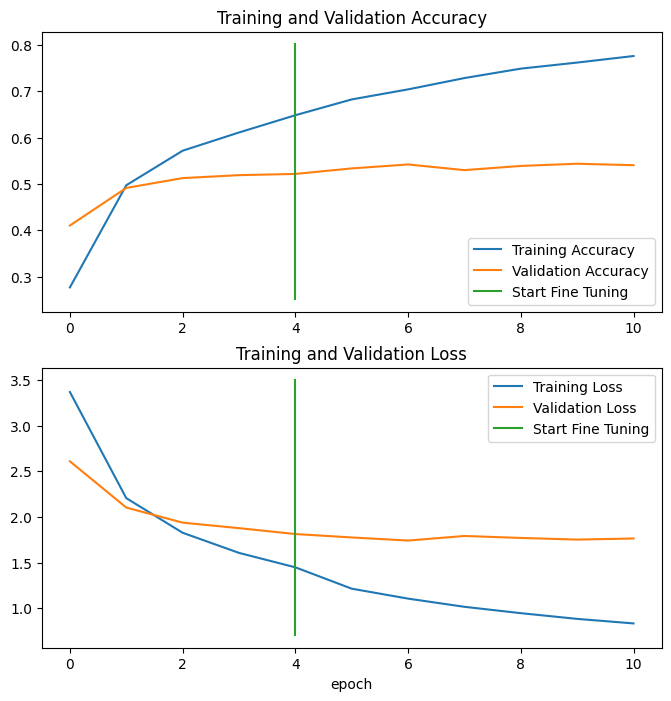

In [25]:
# Compare the historys 
compare_historys(history, history_fine_tune, 5)

 In conclusion, the model is overfitting based on the nature of the loss curves